In [1]:
import pickle
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from unidecode import unidecode

import warnings
warnings.filterwarnings('ignore')

In [2]:
import psycopg2
from local_settings import hostname, username, password, port, database

In [3]:
connection = psycopg2.connect(
            host=hostname, user=username, 
            password=password, dbname=database, 
            port=port
        )

In [4]:
sql_query = "SELECT * FROM data_row"

df = pd.read_sql_query(sql_query, connection)

connection.close()
print(df.shape)
df.head(3)

(26912, 19)


,title,address,price,area,bath,room,property_type,description,year,parking,near_cc,near_school,near_parks,near_avenue,security,elevator,rest_area,pool,web
0,Proyecto inmobilario en venta en Calle Coronel...,"Calle Coronel Odriozola 128, San IsidroLima, Lima",120375,45,2,3,Departamento,Mozz se deriva de la palabra en italiano mozio...,2023,1,1,0,1,0,0,0,1,0,Urbania
1,Proyecto inmobilario en venta en Calle Coronel...,"Calle Coronel Odriozola 128, San IsidroLima, Lima",119277,45,2,3,Departamento,Mozz se deriva de la palabra en italiano mozio...,2023,1,1,0,1,0,0,0,1,0,Urbania
2,Proyecto inmobilario en venta en Calle Coronel...,"Calle Coronel Odriozola 128, San IsidroLima, Lima",162297,60,2,2,Departamento,Mozz se deriva de la palabra en italiano mozio...,2023,1,1,0,1,0,0,0,1,0,Urbania


Due to our own pruporse, we want to study those houses which label is 'Casa' or 'Departamento/Apartemento'. Then we drop out labels like 'Casa de playa', 'Casa de campo' and 'Habitación'.

In [5]:
outhome = ['Casa de playa', 'Casa de campo', 'Habitación']
mask = df['property_type'].apply(lambda x: x not in outhome)
df = df[mask]
df.shape

(26560, 19)

In [6]:
df['property_type'] = df['property_type'].str.replace('Apartamento', 'Departamento')
df['property_type'].value_counts()

property_type
Departamento    19226
Casa             7334
Name: count, dtype: int64

There some values which not correspond actually to Departments or Houses, but entire Hotels, buildings and so on.

In [7]:
id_mansion = df['title'].apply(lambda x: x.lower()).str.extract('((vend\w* edificio|hotel|hostel|mansion|mansión|hostal).*)').dropna().index
df = df.drop(index=id_mansion)
df.shape

(26483, 19)

In [8]:
df = df.drop_duplicates()
df.shape

(22429, 19)

We have already dropped duplicates instances out, but remains some values. So let's be more specific which columns we don't allow duplicates in

In [9]:
df = df.drop_duplicates(subset=['address', 'price', 'area', 'bath', 'room', 'parking', 'year', 'property_type'])
df.shape

(21701, 19)

In [10]:
df['description'].fillna('', inplace=True)
df.isna().sum()

title            0
address          0
price            0
area             0
bath             0
room             0
property_type    0
description      0
year             0
parking          0
near_cc          0
near_school      0
near_parks       0
near_avenue      0
security         0
elevator         0
rest_area        0
pool             0
web              0
dtype: int64

In [11]:
df = df[df['bath'] != 0]
df.shape

(21681, 19)

Once again, due to our own pruporse we just consider departments priced lower than 250,000 USD and houses priced lower than 300,000 USD

In [12]:
threshold_dep = 250000
threshold_casa = 300000
mask = ((df['property_type'] == 'Departamento') & (df['price'] < threshold_dep)) | ((df['property_type'] == 'Casa') & (df['price'] < threshold_casa))
df = df.loc[mask]
df['property_type'].value_counts()

property_type
Departamento    11531
Casa             2839
Name: count, dtype: int64

In [13]:
threshold_dep = 10000
threshold_casa = 15000
mask = ((df['property_type'] == 'Departamento') & (df['price'] > threshold_dep)) | ((df['property_type'] == 'Casa') & (df['price'] > threshold_casa))
df = df.loc[mask]
df['property_type'].value_counts()

property_type
Departamento    11491
Casa             2815
Name: count, dtype: int64

In [14]:
df['id'] = range(0,df.shape[0])
df.set_index('id', inplace=True)
df.head(2)

,title,address,price,area,bath,room,property_type,description,year,parking,near_cc,near_school,near_parks,near_avenue,security,elevator,rest_area,pool,web
id,,,,,,,,,,,,,,,,,,,
0,Proyecto inmobilario en venta en Calle Coronel...,"Calle Coronel Odriozola 128, San IsidroLima, Lima",120375,45,2,3,Departamento,Mozz se deriva de la palabra en italiano mozio...,2023,1,1,0,1,0,0,0,1,0,Urbania
1,Proyecto inmobilario en venta en Calle Coronel...,"Calle Coronel Odriozola 128, San IsidroLima, Lima",119277,45,2,3,Departamento,Mozz se deriva de la palabra en italiano mozio...,2023,1,1,0,1,0,0,0,1,0,Urbania


In [15]:
df['web'].value_counts()

web
Urbania    8929
Mitula     3232
Trovit     2145
Name: count, dtype: int64

## Counties in Lima Provincia

In [16]:
lima_provincia = pd.read_html('https://es.wikipedia.org/wiki/Anexo:Distritos_de_Lima', header=1)[0]
lima_provincia['county'] = lima_provincia['Distritos'].apply(lambda x: unidecode(x).lower())
lima_provincia.head()

,Distritos,Ubigeo,Área (km²),Censo 2017,Estimación 2023[1]​,Fundación,Código postal,Mapa de ubicación,county
0,Ancón,150102,299.22,62 928,91 170,29 de octubre de 1874,2,NaN,ancon
1,Ate,150103,77.72,599 196,713 103,2 de enero de 1857,3,NaN,ate
2,Barranco,150104,3.33,34 378,37 525,26 de octubre de 1874,4,NaN,barranco
3,Breña,150105,3.22,85 309,97 906,15 de julio de 1949,5,NaN,brena
4,Carabayllo,150106,346.88,333 045,426 985,4 de agosto de 1821,6,NaN,carabayllo


In [17]:
county = {kk: vv for kk, vv in zip(lima_provincia['county'], lima_provincia['Ubigeo'])}
county['san martin'] = 150144
county['callao'] = 150145

districts = {
    'surco': 'santiago de surco',
    'cercado de lima': 'lima',
    'magdalena': 'magdalena del mar',
    'provincia de lima': 'lima',
    'cercado': 'lima',
    'limalima': 'lima'
}
for kk, vv in districts.items():
    county[kk] = county[vv]


In [18]:
df['address'] = df['address'].apply(lambda x: unidecode(x).lower())

pattern = '|'.join(county.keys())
df['county'] = df['address'].str.extract(f'({pattern})')[0]
df = df.dropna()

df['county'] = df['county'].apply(lambda x: county[x])
print(df.shape)
df.head(2)

(12988, 20)


,title,address,price,area,bath,room,property_type,description,year,parking,near_cc,near_school,near_parks,near_avenue,security,elevator,rest_area,pool,web,county
id,,,,,,,,,,,,,,,,,,,,
0,Proyecto inmobilario en venta en Calle Coronel...,"calle coronel odriozola 128, san isidrolima, lima",120375,45,2,3,Departamento,Mozz se deriva de la palabra en italiano mozio...,2023,1,1,0,1,0,0,0,1,0,Urbania,150131
1,Proyecto inmobilario en venta en Calle Coronel...,"calle coronel odriozola 128, san isidrolima, lima",119277,45,2,3,Departamento,Mozz se deriva de la palabra en italiano mozio...,2023,1,1,0,1,0,0,0,1,0,Urbania,150131


We want to know the ranking of property accordint to its county

In [19]:
with open("dataset/estratos.pkl", 'rb') as file:
    estratos = pickle.load(file)

estratos = {county[unidecode(kk).lower()]: vv for kk, vv in estratos.items()}
estratos

{150140: 4.59,
 150122: 5.0,
 150131: 5.0,
 150114: 4.76,
 150130: 4.95,
 150141: 4.49,
 150101: 3.21,
 150136: 4.66,
 150113: 5.0,
 150108: 2.71,
 150104: 4.11,
 150116: 4.27,
 150117: 3.22,
 150121: 4.4,
 150120: 5.0,
 150103: 1.51,
 150144: 2.8,
 150118: 1.46,
 150106: 1.9,
 150145: 3.13,
 150115: 3.27,
 150110: 2.36}

In [20]:
df['ranking'] = df['county'].map(estratos)
df.head()

,title,address,price,area,bath,room,property_type,description,year,parking,...,near_school,near_parks,near_avenue,security,elevator,rest_area,pool,web,county,ranking
id,,,,,,,,,,,,,,,,,,,,,
0,Proyecto inmobilario en venta en Calle Coronel...,"calle coronel odriozola 128, san isidrolima, lima",120375,45,2,3,Departamento,Mozz se deriva de la palabra en italiano mozio...,2023,1,...,0,1,0,0,0,1,0,Urbania,150131,5.00
1,Proyecto inmobilario en venta en Calle Coronel...,"calle coronel odriozola 128, san isidrolima, lima",119277,45,2,3,Departamento,Mozz se deriva de la palabra en italiano mozio...,2023,1,...,0,1,0,0,0,1,0,Urbania,150131,5.00
2,Proyecto inmobilario en venta en Calle Coronel...,"calle coronel odriozola 128, san isidrolima, lima",162297,60,2,2,Departamento,Mozz se deriva de la palabra en italiano mozio...,2023,1,...,0,1,0,0,0,1,0,Urbania,150131,5.00
3,Proyecto inmobilario en venta en Calle Coronel...,"calle coronel odriozola 128, san isidrolima, lima",157815,60,2,2,Departamento,Mozz se deriva de la palabra en italiano mozio...,2023,1,...,0,1,0,0,0,1,0,Urbania,150131,5.00
4,Proyecto inmobilario en venta en Jirón Batalló...,"jiron batallon callao norte , santa teresasan...",239998,110,3,3,Departamento,Vive exclusivo en Surco | Vive en Libitum | En...,2023,0,...,0,0,0,0,0,0,0,Urbania,150145,3.13


In [21]:
df.ranking.isna().sum()

1863

As we can see, there are some non-ranked instances. Let's solve this by defining 5 ranges of prices and rank those housings.

In [22]:
mask = (df['property_type'] == 'Departamento') & (df['ranking'].isnull())
df.loc[mask, 'rango'] = pd.cut(df.loc[mask, 'price'], bins=15, labels=range(1, 16))

rango_dict = {
    1: 2.71, 2: 2.36, 3: 2.8, 4: 3.21, 5: 3.27, 
    6: 4.11, 7: 4.27, 8: 4.4, 9: 4.4, 10: 4.49, 
    11: 4.49, 12: 4.66, 13: 4.49, 14: 4.66, 15: 4.76
    }

df['ranking'].fillna(df['rango'].map(rango_dict), inplace=True)
df['ranking'].isna().sum()

738

In [23]:
mask = (df['property_type'] == 'Casa') & (df['ranking'].isnull())
df.loc[mask, 'rango'] = pd.cut(df.loc[mask, 'price'], bins=15, labels=range(1, 16))

rango_dict = {
    1:  1.51, 2: 1.9, 3: 2.36, 4: 2.36, 5: 2.71, 
    6: 2.71, 7: 2.71, 8: 2.8, 9: 2.8, 10: 3.13, 
    11: 2.8, 12: 3.21, 13: 3.22, 14: 3.27, 15: 3.27
    }

df['ranking'].fillna(df['rango'].map(rango_dict), inplace=True)
df['ranking'].isna().sum()

0

In [24]:
df = df.drop(columns='rango')
df['property_type'] = df['property_type'].replace('Departamento', 1).replace('Casa', 2)
print(df.shape)
df.head(3)

(12988, 21)


,title,address,price,area,bath,room,property_type,description,year,parking,...,near_school,near_parks,near_avenue,security,elevator,rest_area,pool,web,county,ranking
id,,,,,,,,,,,,,,,,,,,,,
0,Proyecto inmobilario en venta en Calle Coronel...,"calle coronel odriozola 128, san isidrolima, lima",120375,45,2,3,1,Mozz se deriva de la palabra en italiano mozio...,2023,1,...,0,1,0,0,0,1,0,Urbania,150131,5.0
1,Proyecto inmobilario en venta en Calle Coronel...,"calle coronel odriozola 128, san isidrolima, lima",119277,45,2,3,1,Mozz se deriva de la palabra en italiano mozio...,2023,1,...,0,1,0,0,0,1,0,Urbania,150131,5.0
2,Proyecto inmobilario en venta en Calle Coronel...,"calle coronel odriozola 128, san isidrolima, lima",162297,60,2,2,1,Mozz se deriva de la palabra en italiano mozio...,2023,1,...,0,1,0,0,0,1,0,Urbania,150131,5.0


# EDA

## Variable Distribution

In [ ]:
df.columns

Index(['title', 'address', 'price', 'area', 'bath', 'room', 'property_type',
       'description', 'year', 'parking', 'near_cc', 'near_school',
       'near_parks', 'near_avenue', 'security', 'elevator', 'rest_area',
       'pool', 'web', 'county', 'ranking', 'rango'],
      dtype='object')

Let's create a new dataframe which contains only the numerical variables, i.e., 'price', 'area', 'bath', 'room', 'parking' and 'year'.

In [27]:
df_num = df[['price', 'area', 'bath', 'room', 'parking', 'year', 'property_type',
             'near_cc', 'near_school', 'near_parks', 'near_avenue', 'security', 
             'elevator', 'rest_area','pool', 'county', 'ranking']]
df_num.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12988 entries, 0 to 14305
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          12988 non-null  int64  
 1   area           12988 non-null  int64  
 2   bath           12988 non-null  int64  
 3   room           12988 non-null  int64  
 4   parking        12988 non-null  int64  
 5   year           12988 non-null  int64  
 6   property_type  12988 non-null  int64  
 7   near_cc        12988 non-null  int64  
 8   near_school    12988 non-null  int64  
 9   near_parks     12988 non-null  int64  
 10  near_avenue    12988 non-null  int64  
 11  security       12988 non-null  int64  
 12  elevator       12988 non-null  int64  
 13  rest_area      12988 non-null  int64  
 14  pool           12988 non-null  int64  
 15  county         12988 non-null  int64  
 16  ranking        12988 non-null  float64
dtypes: float64(1), int64(16)
memory usage: 1.8 MB


As the first step, we plot the distribution of each variable in order to know where its outliers.

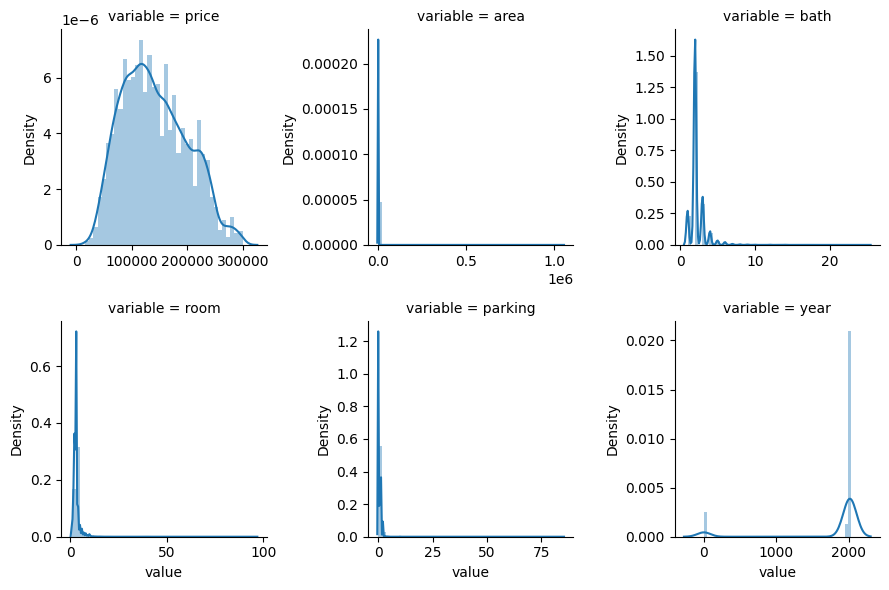

In [28]:
f = pd.melt(df_num.iloc[:,:6], value_vars=df_num.columns[:6])
g = sns.FacetGrid(f, col="variable",  col_wrap=3, sharex=False, sharey=False)
g = g.map(sns.distplot, "value")

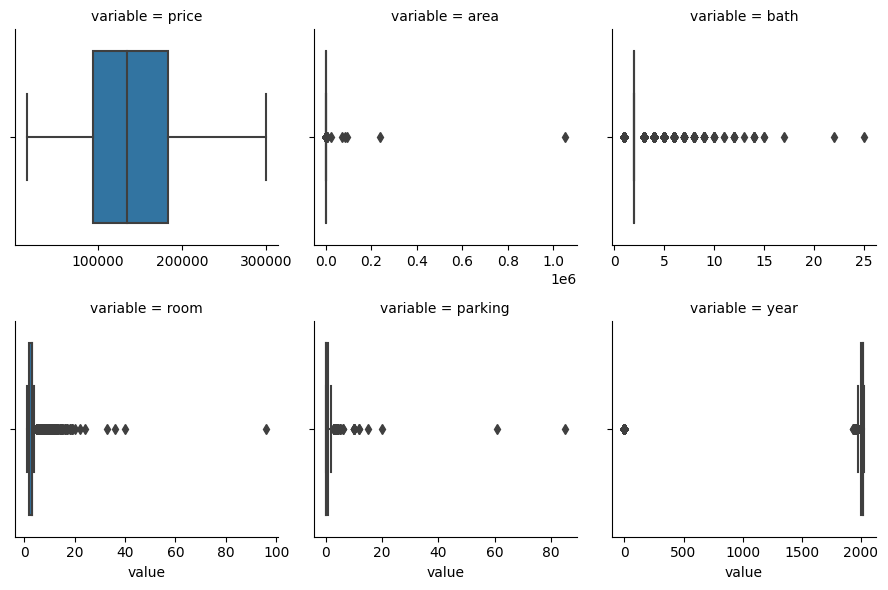

In [29]:
f = pd.melt(df_num.iloc[:,:6], value_vars=df_num.columns[:6])
g = sns.FacetGrid(f, col="variable",  col_wrap=3, sharex=False, sharey=False)
g = g.map(sns.boxplot, "value")

As we can appreciate, all variables have outliers, but 'price'. 

In [30]:
def outliers(column, df_outlier):
    Q1 = df_outlier[column].dropna().quantile(0.25)
    Q3 = df_outlier[column].dropna().quantile(0.75)
    IQR = Q3 - Q1

    lower_whisker = Q1 - 1.5 * IQR
    upper_whisker = Q3 + 1.5 * IQR

    return lower_whisker, upper_whisker

We point out for clients which buy its first house, then a housing which has a big area would not be a good option for a first house.

In [31]:
threshold = 500
mask = (df_num['area'] < threshold)
df_num = df_num[mask]
df_num.shape

(12897, 17)

## Outliers Casa & Departamento

Because Department and Houses has different dimensions and settings, we split the analysis among each property_type label.

In [34]:
mask = df_num['property_type'] == 1
df_departamento = df_num.loc[mask]
mask = df_num['property_type'] == 2
df_casa = df_num.loc[mask]
print(df_departamento.shape, df_casa.shape)

(10836, 17) (2061, 17)


### Departamento

#### Outliers Area

We choose 'area' for our standard parameter, in order to contrast the other variables and take a decision aboout what instance gets drop out.

In [35]:
lower_darea, upper_darea = outliers('area', df_departamento)
lower_darea, upper_darea

(5.0, 165.0)

Hence using the outlier values, let's see which instance could be useful. For that a 2D histogram would be a good idea to see how data of 'area' and number of 'room' is distributed.

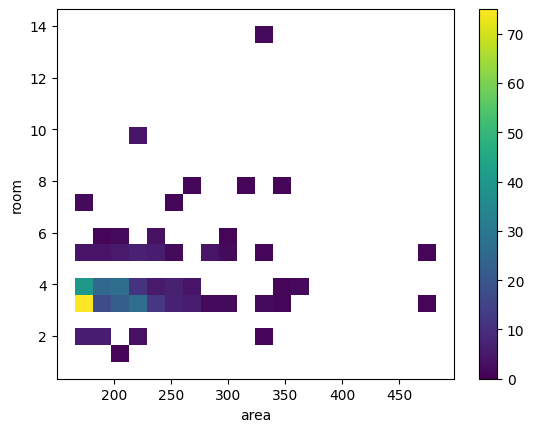

In [36]:
mask = df_departamento['area'] > upper_darea
plt.figure()
sns.histplot(data=df_departamento.loc[mask], x='area', y='room', bins=20, cmap='viridis', cbar=True)
plt.show()

For this data, let's see what is the most common range for number of rooms

In [37]:
mask = (df_departamento['area'] > upper_darea)
lower_room, upper_room = outliers('room', df_departamento[mask])
lower_room, upper_room

(1.5, 5.5)

According to this result, housing having more that 5 rooms and less than 3 room are dropped out.

In [38]:
mask = (df_departamento['area'] > upper_darea) & ((df_departamento['room'] <= 2)|(df_departamento['room'] >= 6))
print(df_departamento.loc[mask].shape)
df_departamento = df_departamento.loc[~mask]
df_departamento.shape

(36, 17)


(10800, 17)

Let's do the same for 'bath' variable

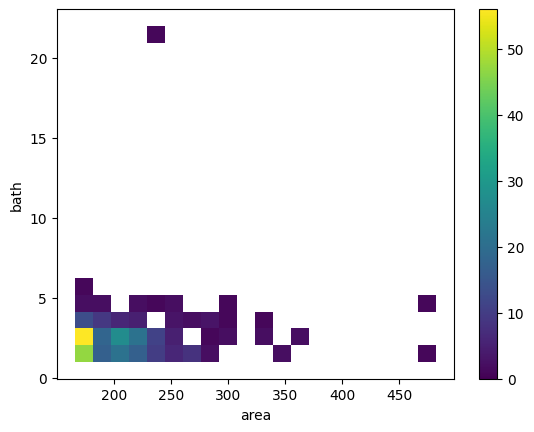

In [39]:
mask = df_departamento['area'] > upper_darea
plt.figure()
sns.histplot(data=df_departamento.loc[mask], x='area', y='bath', bins=20, cmap='viridis', cbar=True)
plt.show()

As well as before, instaces with more then 5 and less than 2 bath are dropped out.

In [40]:
mask = (df_departamento['area'] > upper_darea) & ((df_departamento['bath'] <= 1)|(df_departamento['bath'] >= 6))
print(df_departamento[mask].shape)
df_departamento = df_departamento.loc[~mask]
df_departamento.shape

(5, 17)


(10795, 17)

#### Outliers Room & Bath

Now let's analyses the variables 'room' and 'bath' for itself.
Let's compute its outliers and let them go away.

In [41]:
lower_droom, upper_droom = outliers('room', df_departamento)
lower_droom, upper_droom

(0.5, 4.5)

In [42]:
mask = df_departamento['room'] < 5
print(df_departamento[~mask].shape)
df_departamento = df_departamento[mask]
df_departamento.shape

(105, 17)


(10690, 17)

In [43]:
lower_dbath, upper_dbath = outliers('bath', df_departamento)
lower_dbath, upper_dbath

(2.0, 2.0)

In [44]:
mask = df_departamento['bath'] < 5
print(df_departamento[~mask].shape)
df_departamento = df_departamento.loc[mask]
df_departamento.shape

(25, 17)


(10665, 17)

#### Bath < Room

Now let's analyse both parameters together.

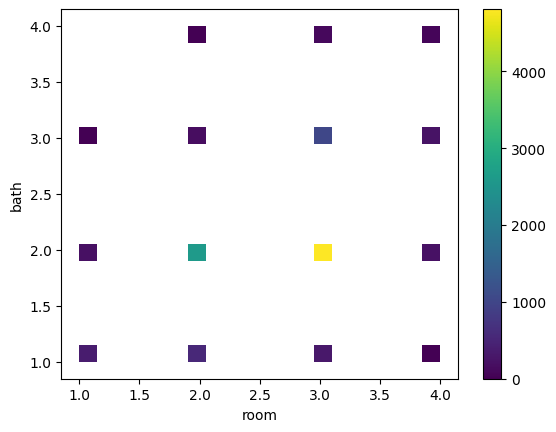

In [45]:
plt.figure()
sns.histplot(data=df_departamento.loc[mask], x='room', y='bath', bins=20, cmap='viridis', cbar=True)
plt.show()

We can appreciate than there are several cases where exist more bath than rooms. Let's drop out that instances.

In [46]:
mask = df_departamento['bath'] > df_departamento['room']
print(df_departamento[mask].shape)
df_departamento = df_departamento.loc[~mask]
df_departamento.shape

(482, 17)


(10183, 17)

#### Outlier Parking

In [47]:
lower_dparking, upper_dparking = outliers('parking', df_departamento)
lower_dparking, upper_dparking

(-1.5, 2.5)

In [48]:
mask = df_departamento['parking'] <= 2
df_departamento = df_departamento.loc[mask]
df_departamento.shape

(10170, 17)

In [49]:
df_departamento['parking'] = df_departamento['parking'].replace(2, 1)
df_departamento.shape

(10170, 17)

In [50]:
df_departamento['parking'].value_counts()

parking
0    6454
1    3716
Name: count, dtype: int64

#### Outlier Year

There are some data in 'year' which is 0, let's replaced by random values, between 2000 and 2020

In [51]:
# mask = (df_departamento['year'] != 0) & (df_departamento['year'] != 2023) 
# new_year = int(df_departamento.loc[mask, 'year'].median())
mask = df_departamento['year'] == 0
size = df_departamento.loc[mask].shape[0]
df_departamento.loc[mask, 'year'] = np.random.normal(2010, 5, size).astype(int)
df_departamento.shape

(10170, 17)

In [52]:
mask = df_departamento['year'] > 2023
df_departamento.loc[mask, 'year'] = [2023] * df_departamento.loc[mask].shape[0]
df_departamento['year'] = df_departamento['year'].astype(int)
df_departamento['year'].value_counts()

year
2023    3783
2013     490
2022     470
2018     358
2008     320
        ... 
1946       1
1947       1
1949       1
1941       1
1950       1
Name: count, Length: 76, dtype: int64

Let's see how the distributions have changed

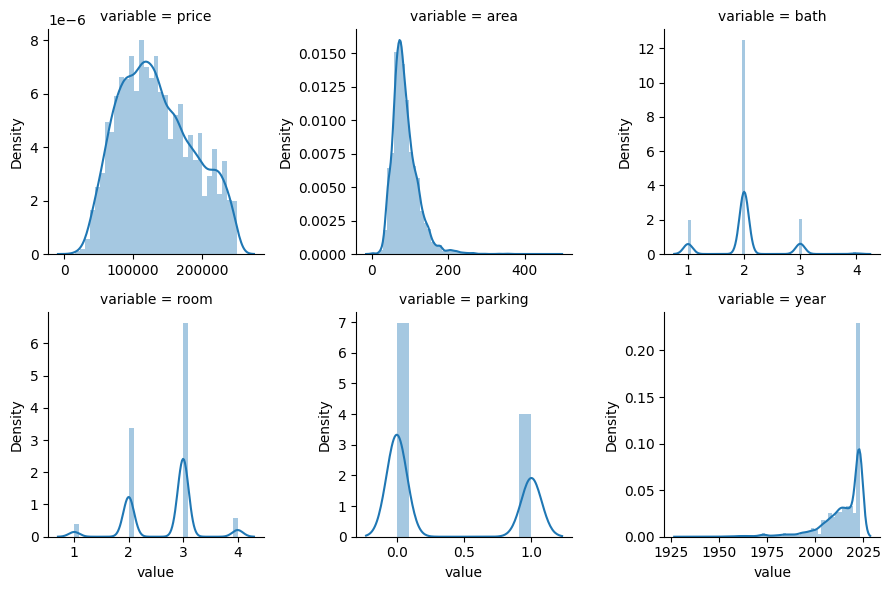

In [53]:
f = pd.melt(df_departamento.iloc[:,:6], value_vars=df_departamento.columns[:6])
g = sns.FacetGrid(f, col="variable",  col_wrap=3, sharex=False, sharey=False)
g = g.map(sns.distplot, "value")

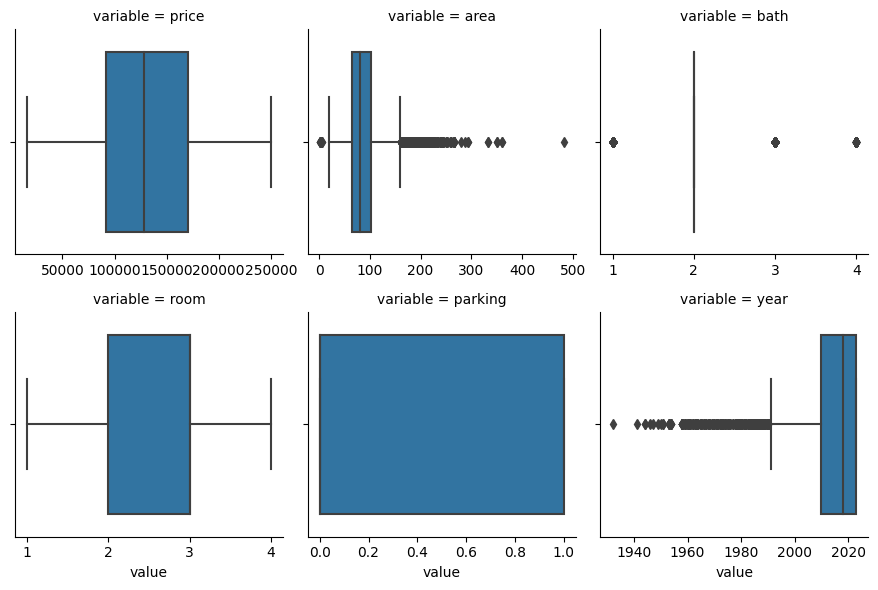

In [54]:
f = pd.melt(df_departamento.iloc[:,:6], value_vars=df_departamento.columns[:6])
g = sns.FacetGrid(f, col="variable",  col_wrap=3, sharex=False, sharey=False)
g = g.map(sns.boxplot, "value")

### Casa

#### Outliers Area

In [55]:
lower_carea, upper_carea = outliers('area', df_casa)
lower_carea, upper_carea

(-33.5, 362.5)

In [56]:
mask = df_casa['area'] > upper_carea
df_casa = df_casa.loc[~mask]


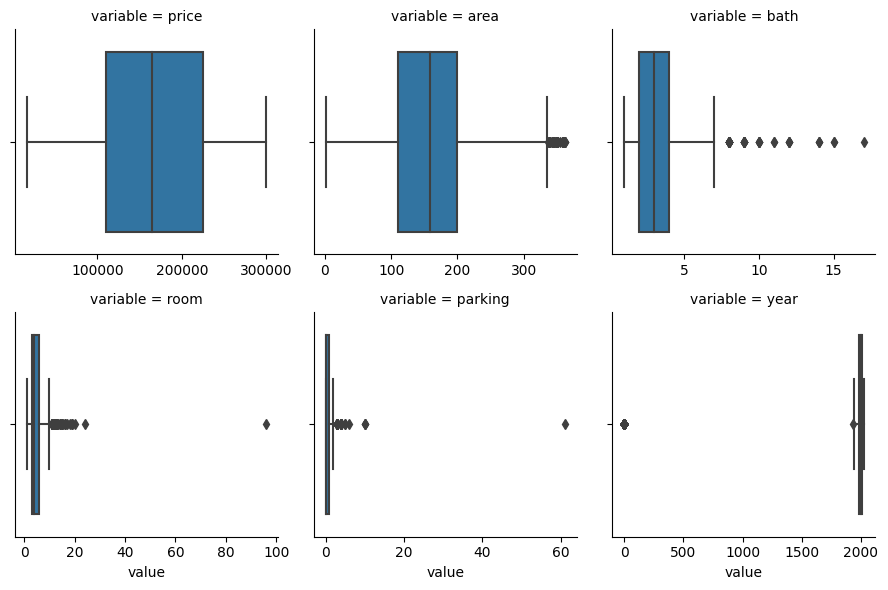

In [57]:
f = pd.melt(df_casa.iloc[:,:6], value_vars=df_casa.columns[:6])
g = sns.FacetGrid(f, col="variable",  col_wrap=3, sharex=False, sharey=False)
g = g.map(sns.boxplot, "value")

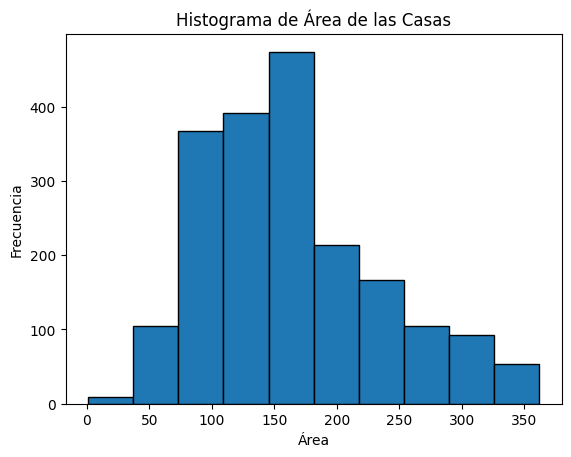

In [58]:
plt.hist(df_casa["area"], edgecolor='k')

# Configurar etiquetas y título
plt.xlabel("Área")
plt.ylabel("Frecuencia")
plt.title("Histograma de Área de las Casas")

# Mostrar el gráfico
plt.show()


In [59]:
mask = df_casa['area'] < 30
df_casa = df_casa.loc[~mask]

#### Outliers Room & Bath

In [60]:
lower_croom, upper_croom = outliers('room', df_casa)
lower_croom, upper_croom

(-1.5, 10.5)

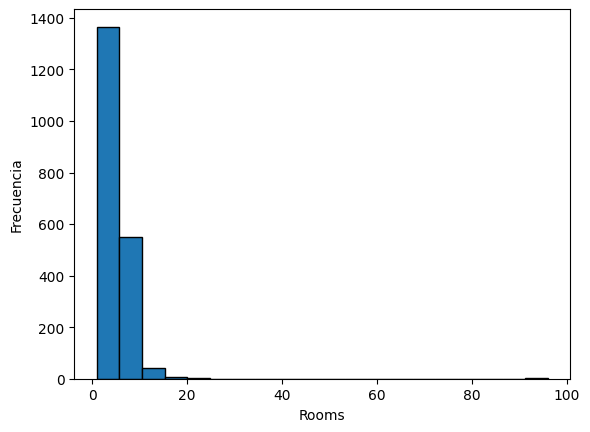

In [61]:
plt.hist(df_casa["room"], edgecolor='k', bins= 20)

# Configurar etiquetas y título
plt.xlabel("Rooms")
plt.ylabel("Frecuencia")
plt.show()


In [62]:
mask = df_casa['room'] > 10
df_casa = df_casa[~mask]
df_casa.shape

(1916, 17)

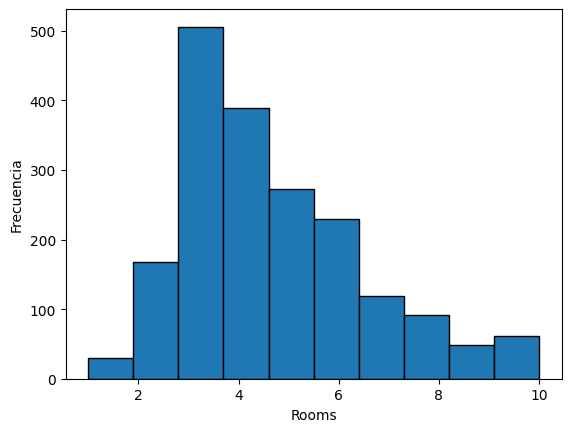

In [63]:
plt.hist(df_casa["room"], edgecolor='k')

# Configurar etiquetas y título
plt.xlabel("Rooms")
plt.ylabel("Frecuencia")
plt.show()


In [64]:
#id_hotel = df[df["room"] >10]['description'].apply(lambda x: x.lower()).str.extract('(hotel)').dropna().index
#df.loc[id_hotel]

In [65]:
lower_cbath, upper_cbath = outliers('bath', df_casa)
lower_cbath, upper_cbath

(-1.0, 7.0)

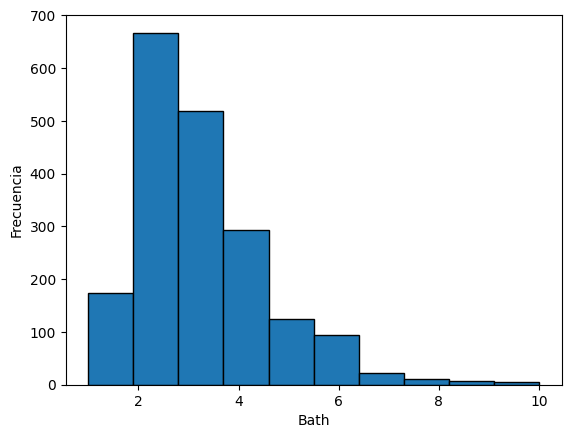

In [66]:
plt.hist(df_casa["bath"], edgecolor='k')

# Configurar etiquetas y título
plt.xlabel("Bath")
plt.ylabel("Frecuencia")
plt.show()


In [67]:
mask = df_casa['bath'] > 7
df_casa = df_casa[~mask]
df_casa.shape

(1893, 17)

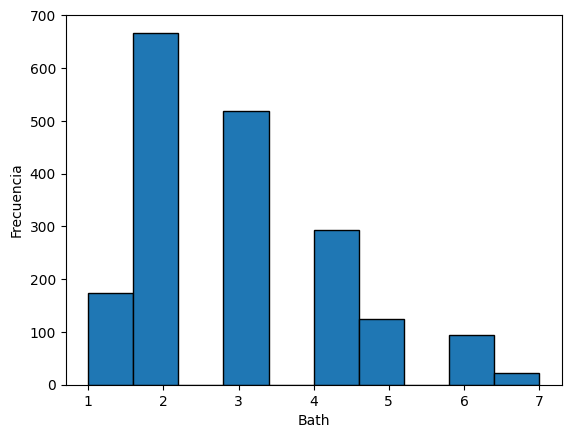

In [68]:
plt.hist(df_casa["bath"], edgecolor='k')

# Configurar etiquetas y título
plt.xlabel("Bath")
plt.ylabel("Frecuencia")
plt.show()


#### Bath < Room

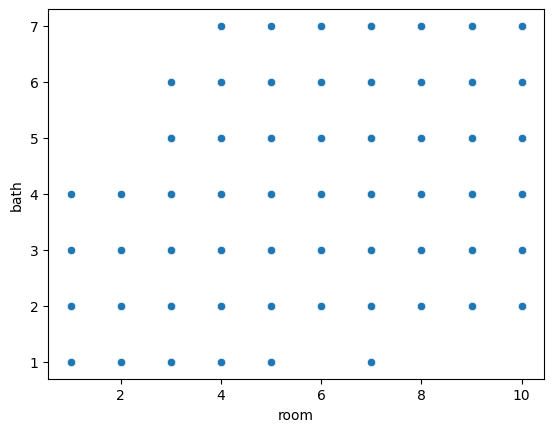

In [69]:
plt.figure()
sns.scatterplot(data=df_casa, x='room', y='bath')
plt.show()

In [70]:
mask = df_casa['bath'] > df_casa['room']
df_casa = df_casa.loc[~mask]
df_casa.shape

(1813, 17)

#### Outlier Parking

In [71]:
lower_cparking, upper_cparking = outliers('parking', df_casa)
lower_cparking, upper_cparking

(-1.5, 2.5)

In [72]:
mask = df_casa['parking'] <= 2
df_casa = df_casa.loc[mask]


In [73]:
df_casa['parking'] = df_casa['parking'].replace(2, 1)
df_casa.shape

(1780, 17)

In [74]:
df_casa['parking'].value_counts()

parking
0    1041
1     739
Name: count, dtype: int64

#### Outlier Year

In [75]:
df_casa.loc[df_casa['year'] == 0]

,price,area,bath,room,parking,year,property_type,near_cc,near_school,near_parks,near_avenue,security,elevator,rest_area,pool,county,ranking
id,,,,,,,,,,,,,,,,,
162,205000,160,2,4,1,0,2,0,0,0,0,0,0,0,0,150135,2.80
413,178378,338,2,4,0,0,2,1,0,1,1,0,0,0,0,150101,3.21
1214,280000,360,5,6,1,0,2,0,0,1,0,0,0,1,0,150101,3.21
1353,60000,149,2,3,0,0,2,0,0,0,0,0,0,0,0,150108,2.71
2344,170000,350,5,9,0,0,2,0,0,0,0,0,0,0,0,150142,2.80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14188,290000,320,3,3,0,0,2,1,1,1,1,0,0,0,0,150127,3.27
14199,56000,77,2,5,0,0,2,1,1,1,1,0,0,0,0,150145,3.13
14212,270000,200,3,4,1,0,2,0,1,1,1,0,0,1,0,150111,3.27


In [76]:
df_casa["year"].value_counts()

year
0       266
2013    118
2023    104
2008     83
1993     76
       ... 
1933      1
1947      1
1940      1
1982      1
1950      1
Name: count, Length: 74, dtype: int64

In [77]:
mask = (df_casa['year'] != 0) & (df_casa['year'] != 2023) 
new_year = int(df_casa.loc[mask, 'year'].median())
df_casa['year'] = df_casa['year'].replace(0, new_year)
df_casa.shape

(1780, 17)

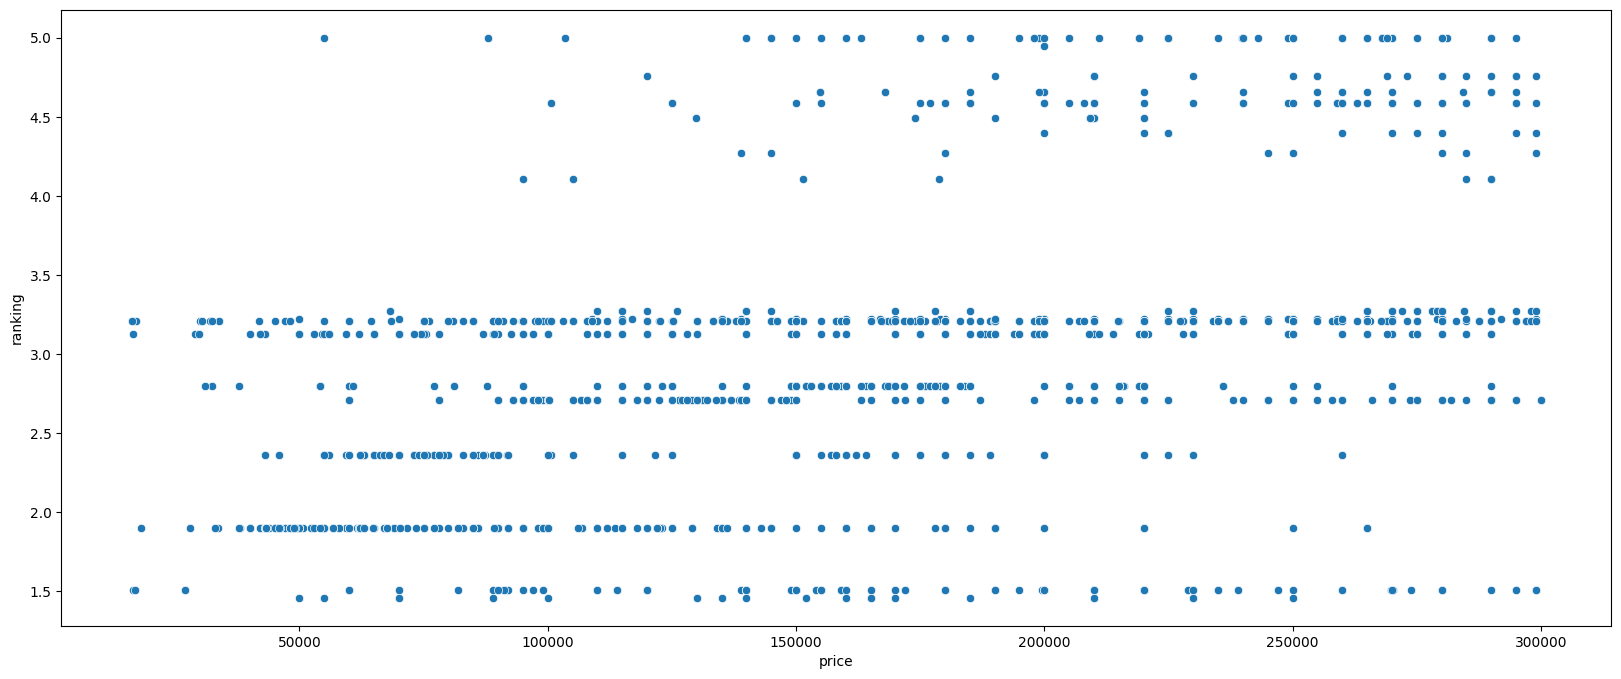

In [78]:
plt.figure(figsize= (20,8))
sns.scatterplot(data=df_casa, x='price', y='ranking')
plt.show()

## Concat both datasets

In [84]:
print(df_departamento.shape)
df_departamento.head()

(10170, 17)


,price,area,bath,room,parking,year,property_type,near_cc,near_school,near_parks,near_avenue,security,elevator,rest_area,pool,county,ranking
id,,,,,,,,,,,,,,,,,
0,120375,45,2,3,1,2023,1,1,0,1,0,0,0,1,0,150131,5.00
1,119277,45,2,3,1,2023,1,1,0,1,0,0,0,1,0,150131,5.00
2,162297,60,2,2,1,2023,1,1,0,1,0,0,0,1,0,150131,5.00
3,157815,60,2,2,1,2023,1,1,0,1,0,0,0,1,0,150131,5.00
4,239998,110,3,3,0,2023,1,1,0,0,0,0,0,0,0,150145,3.13


In [85]:
print(df_casa.shape)
df_casa.head()

(1780, 17)


,price,area,bath,room,parking,year,property_type,near_cc,near_school,near_parks,near_avenue,security,elevator,rest_area,pool,county,ranking
id,,,,,,,,,,,,,,,,,
47,134000,149,6,8,1,2014,2,1,1,1,0,1,0,1,1,150106,1.90
58,200000,113,3,7,1,1998,2,1,0,0,1,0,0,1,0,150136,4.66
60,170000,190,3,5,0,2018,2,1,1,1,0,1,0,1,1,150118,1.46
92,179000,140,2,3,1,1978,2,1,0,0,0,0,0,1,0,150133,2.80
94,134000,149,2,8,1,2023,2,1,1,1,0,1,0,1,0,150106,1.90


In [83]:
df_final = pd.concat([df_departamento, df_casa], ignore_index=True)
print(df_final.shape)
df_final.head()

(11950, 17)


,price,area,bath,room,parking,year,property_type,near_cc,near_school,near_parks,near_avenue,security,elevator,rest_area,pool,county,ranking
0,120375,45,2,3,1,2023,1,1,0,1,0,0,0,1,0,150131,5.00
1,119277,45,2,3,1,2023,1,1,0,1,0,0,0,1,0,150131,5.00
2,162297,60,2,2,1,2023,1,1,0,1,0,0,0,1,0,150131,5.00
3,157815,60,2,2,1,2023,1,1,0,1,0,0,0,1,0,150131,5.00
4,239998,110,3,3,0,2023,1,1,0,0,0,0,0,0,0,150145,3.13


In [86]:
# df_final.to_csv("./dataset/data_county_final.csv")

### Postgres

In [87]:
import psycopg2
from sqlalchemy import create_engine
from local_settings import hostname, username, password, port, database

In [88]:
connection = psycopg2.connect(
            host=hostname, user=username, 
            password=password, dbname=database, 
            port=port
        )

engine = create_engine(f'postgresql://{username}:{password}@{hostname}:{port}/{database}')

In [91]:
# DO NOT UNCOMMENT UNLEES YOU KNOW WHAT YOU ARE DOING
# df_final.to_sql('data_model_county', engine, if_exists='replace', index=False)

In [90]:
connection.close()